# Cutting pattern
for Fujii-Echelle

Balmer series:

|line     | $\lambda$, nm|
|--       |            --|
|H $\alpha$ |656.279       |
|H $\beta$  |486.135       |

## Imports and Setup

In [1]:
%matplotlib inline

In [2]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import peakutils
import pandas as pd
from PIL import Image
from aklab.mpls import font_setup
from lmfit.models import GaussianModel

In [34]:
from tifffile import TiffFile

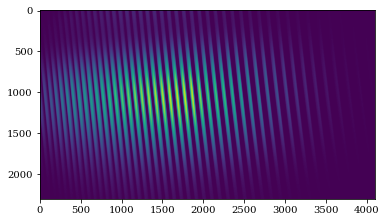

In [37]:
with TiffFile('LED.tif') as tif:
    data = tif.asarray()

plt.imshow(data)

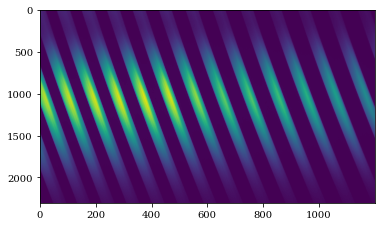

In [42]:
sekibun = data.T[1400:2600].T
offset = sekibun.min()
plt.imshow(data.T[1400:2600].T-offset,aspect=0.3)

In [78]:
# Transpose to get the lines closer to horizontal
image = np.array(Image.open('LED.tif')).T
# Crop image
image = image[1400:2600]

In [46]:
#plt.imshow(image,origin='lower')

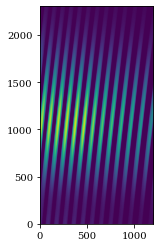

In [79]:
plt.imshow(image.T,origin='lower')

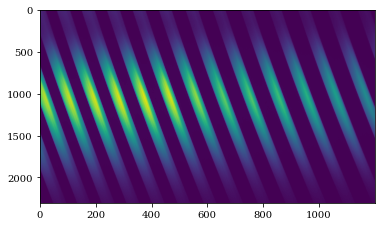

In [82]:
#sekibun = image[1400:2600].T
sekibun = image.T
offset = sekibun.min()
plt.imshow(sekibun-offset,aspect = 0.3)

In [83]:
from scipy.signal import savgol_filter

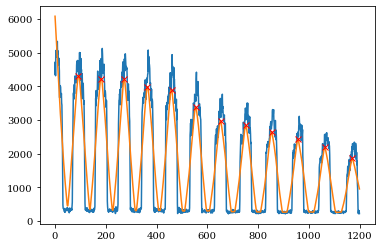

In [96]:
i = 100
THRESHOLD = 0.06
MIN_DISTANCE = 60 
plt.plot(sekibun[i])
d = savgol_filter(sekibun[i],41,1)
plt.plot(d)
peaks = peakutils.indexes(d,thres=THRESHOLD,min_dist=MIN_DISTANCE)
plt.plot(np.arange(sekibun.shape[1])[peaks],d[peaks],'xr')

In [72]:
sekibun.shape

(2304, 1200)

In [5]:
ny,nx = image.shape
nx,ny

(2304, 4096)

# Extract peak positions

## Check signal, select amplifier
Because intensity for higher orders may drop significantly, for best peak detection
it is better to amplify weak intensities. Here, select this `amplifier` function.

### Smooth signal

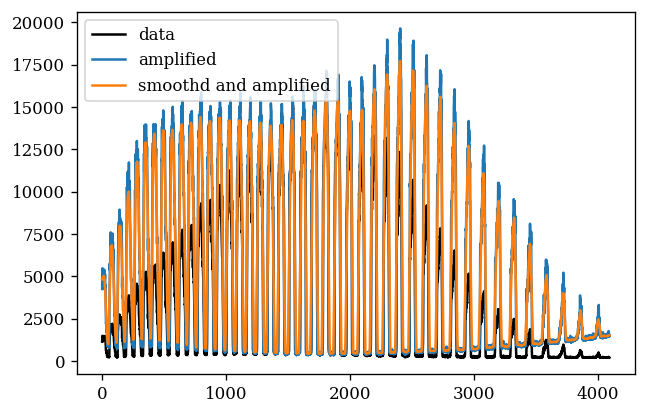

In [73]:
x = np.arange(ny)
slice_y_at = 500
y=image[:,slice_y_at]
ysm = savgol_filter(y, 21, 1)
# For Black Echelle
#amp = np.exp(5e-4 * x) # amplify weak signal for higher orders
# For Fujii Echelle
amp = 1+(1e-3*(x-len(x)//2.5))**2
plt.plot(y, 'k',label='data')
plt.plot(y * amp,label='amplified')
plt.plot(ysm * amp,label='smoothd and amplified')
plt.legend()
plt.gcf().set_dpi(120)

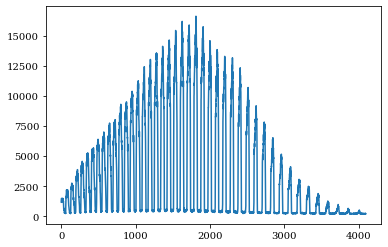

In [77]:
x = np.arange(ny)
slice_y_at = 500
y=image[:,slice_y_at]

plt.plot(x,y)

### Check

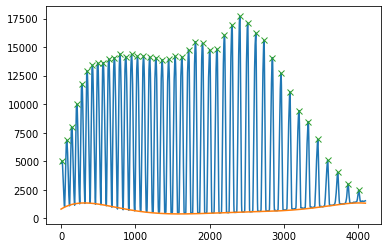

In [7]:
# calculate baseline
base = peakutils.baseline(ysm*amp, 6)
# adjust parameters for correct peak detection
THRESHOLD = 0.06
MIN_DISTANCE = 60 
ind = peakutils.indexes(ysm*amp-base, thres=THRESHOLD, min_dist=MIN_DISTANCE)
plt.plot(ysm*amp)
plt.plot(base)
plt.plot(ind, ysm[ind]*amp[ind], 'x')

## Peak positions over image

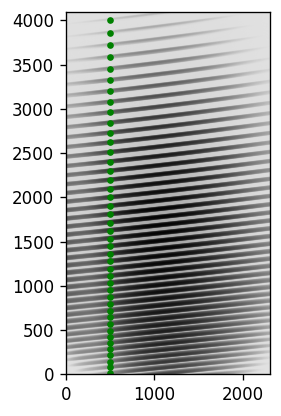

In [8]:
scale=1
norm=mpl.colors.LogNorm(image.min(), image.max() * scale)
plt.imshow(image, origin="lower", cmap="binary",norm=norm)
x = np.ones(ind.shape[0]) * slice_y_at
plt.plot(x, ind, '.g')
plt.gcf().set_dpi(120)

## Detect all and plot

Define positions for peak selection. Even distribution from center, which is the brightest.

If not all peaks are detected correctly, there will be different number of results for each `x` pixel in `xselec`.
If so, no fitting is done. Adjust peak finding parameters `thres` and `min_dist` to get all peaks, and no extra.

Adjust peak finding parameters, [42 43]


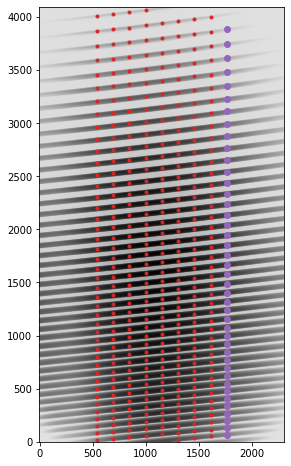

In [9]:
dx = nx // 15
n = 4
# center = nx//2
center = nx//2
xselect = np.arange(center - dx * n, center + dx * n + 1, dx, dtype=int)
x = np.arange(ny)
amp = 1+(1e-3*(x-len(x)//2.5))**2

peaks = []
pvals = []
for xind in xselect:
    y=image[:, xind]
    ysm = savgol_filter(y, 21, 1)
    base = peakutils.baseline(ysm*amp, 6)
    ind = peakutils.indexes(ysm*amp - base, thres=THRESHOLD, min_dist=MIN_DISTANCE)
    peaks.append(ind)
    pvals.append(ysm[ind])

# check if all peaks were detected
uniques = np.unique([len(i) for i in peaks])
if uniques.shape[0] > 1:
    print("Adjust peak finding parameters,", uniques)
else:
    print("Shape's good!\nBut check the image, did we get everything?")
    pat_y = np.array(peaks)
    # fit quadratics
    fits = [np.poly1d(np.polyfit(xselect, i, 1)) for i in pat_y.T]
    x = np.arange(nx)
    pattern = np.array([f(x) for f in fits], dtype=int)
    # plot fits
    for p in pattern:
        plt.plot(p, 'C1')

scale = 1    
norm = mpl.colors.LogNorm(image.min(), image.max() * scale)
plt.imshow(image, origin="lower", cmap="binary",norm=norm)


# plot peaks
for ind,px in zip(peaks, xselect):
    x = np.ones(ind.shape[0]) * px
    plt.plot(x, ind, '.C3')

plt.plot(x, ind, 'oC4')


plt.gcf().set_size_inches([8, 8])

# Manual adjust
Adjust the list of peaks manually

In [10]:
peaks_manual = []
for i in range(5):
    peaks_manual.append(np.concatenate([[np.nan],peaks[i]]))
    
for i in range(5,8+1):
    peaks_manual.append(np.concatenate([peaks[i],[np.nan]]))

peaks_manual = pd.DataFrame(peaks_manual).T
pm = peaks_manual.values

In [11]:
#plt.imshow(image, origin="lower", cmap="binary")
colors = ['C1','C2']

pattern = []
for j,i in enumerate(pm):
    mask = ~np.isnan(i)    
    x = np.arange(nx)
    fit = np.poly1d(np.polyfit(xselect[mask], i[mask], 2))
    y = fit(x)
    y[y<0] = np.nan
    y[y>ny] = np.nan
    pattern.append(y)

    #plt.plot(xselect,i,'.',c=colors[j%2])
    #plt.plot(x,y,'-',c=colors[j%2])

#plt.ylim(3500,ny)
#plt.ylim(0,1000)
pattern = np.array(pattern)

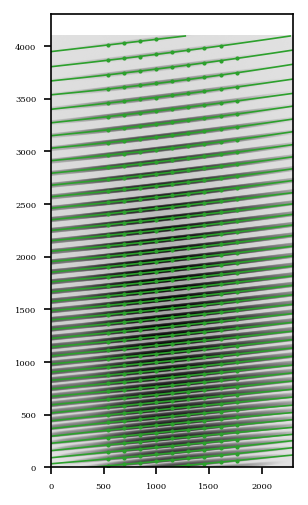

In [12]:
font_setup(size='4')
scale=1
norm=mpl.colors.LogNorm(image.min(), image.max() * scale)
plt.imshow(image, origin="lower", cmap="binary",norm=norm)


_ = [plt.plot(i,c='C2',lw=0.8) for i in pattern]

for ind,px in zip(peaks, xselect):
    x = np.ones(ind.shape[0]) * px
    plt.plot(x, ind, 'oC2',ms=1)

plt.gcf().set_dpi(150)
plt.savefig('Fechelle-Pattern-Fit.pdf', bbox_inches='tight')

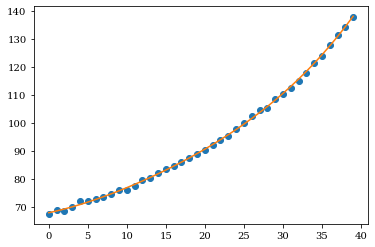

In [13]:
font_setup(size='10')
# Get order spacing
nord = 4
dy = np.gradient(pm[:,nord])
dy = dy[~np.isnan(dy)]
dx = np.arange(dy.shape[0])
order_space = np.poly1d(np.polyfit(dx,dy, 4))
plt.plot(dx,dy,'o')
plt.plot(dx,order_space(dx))

In [14]:
from aklab import mpls as akmp

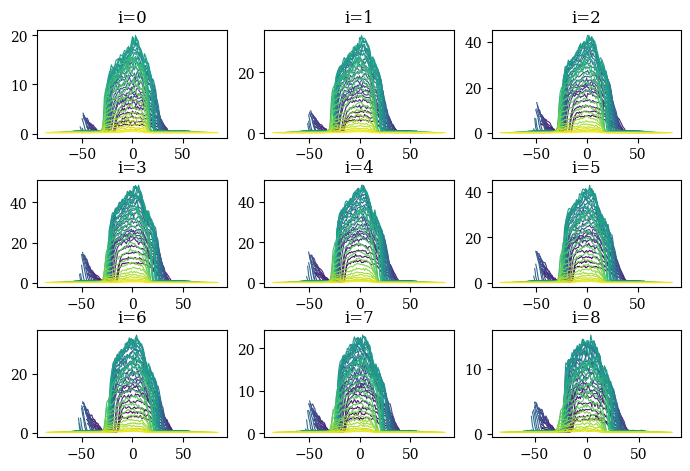

In [15]:
# select order
orders = range(pm.shape[0])
color = plt.cm.viridis(np.linspace(0, 1, len(orders)))
fig, axs = akmp.figprep(600,[3,3],ratio=0.5)

for k, nord in enumerate(orders):
#for nord in range(0,7):
    for i in range(9):
        #i = 8
        X = int(xselect[i])
        try:
            Y = int(pm[nord,i])        
        except ValueError:
            #print(f'nord={nord}, i={i}, Y = {pm[nord,i]}, skipped')
            continue
            
        y = np.arange(ny)
        intensity = image[:,X]
        # half window in pixels
        win = int(order_space(nord)/2) + 10
        while Y-win<0:
            win-=1
        while Y+win > ny:
            win-=1

        ax = axs[i//3,i%3]
        #plt.plot(y[Y-win:Y+win],intensity[Y-win:Y+win])
        #plt.axvline(Y,c='k')
        sy = np.arange(-win,win)
        ax.plot(sy,intensity[Y-win:Y+win]/1e3,c=color[k],lw=0.8)
        ax.set_title(f'i={i}')

    
#plt.axvline(40,c='k')
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.2)
plt.gcf().set_dpi(100)
plt.savefig('Fechelle-order-profiles.pdf', bbox_inches='tight')

## How to detect width?
What if we just measure Full Width at Half Maximum? That'll do.
Also, just try fitting it with a Gaussian

In [16]:
from ast import Raise


def get_point_profile(nord,i,args):
    """
    Parameters
    ==========
    nord: int
        order number
    i: int
        number of a test point used to get the order profile shape
    args: list with data
        args = xselect,pm,order_space,win,image = args
    """
    xselect,pm,order_space,image = args
    X = int(xselect[i])
    intensity = image[:,X]
    try:
        Y = int(pm[nord,i])        
    except ValueError:
        raise ValueError(f'nord={nord}, i={i}, Y = {pm[nord,i]}, skipped')
        
    # half window in pixels
    win = int(order_space(nord)/2) + 10
    while Y-win<0:
        win-=1
    while Y+win > ny:
        win-=1
    sy = np.arange(-win,win)
    z = intensity[Y-win:Y+win]
    z =  z-z.min()
    z = z/z.max()
    return sy,z, win

def make_models(sy,z,win,n=2):
    """
    Generage lmfit models to fit the order profile, to find it's center and width

    Parameters
    ==========
    sy: np.array
        vertical pixel
    z: np.array
        image intensity across a vertical line, selected in get_point_profile
    win: int
        window size
    n: int
        number of Gaussians to approximate the profile shape
    """
    # Main peak
    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.guess(z, x=sy)
    pars['g1_center'].set(value=0, min=-win/2, max=+win/2)
    pars['g1_sigma'].set(value=10, min=10,max=15)
    pars['g1_amplitude'].set(value=100, min=1,max=200)
    pars.add('dlam', value=0, min = -win/5,max=win/5)
    pars.add('drl', value=win, min = win,max=win*1.5)

    # If left or right orders are inside a window, add two gaussians
    gaussl = GaussianModel(prefix='gl_')
    pars.update(gaussl.make_params())
    pars['gl_center'].set(expr='g1_center - drl')
    pars['gl_sigma'].set(value=10, min=10,max=15)
    pars['gl_amplitude'].set(value=100, min=0,max=200)

    gaussr = GaussianModel(prefix='gr_')
    pars.update(gaussr.make_params())
    pars['gr_center'].set(expr='g1_center + drl')
    pars['gr_sigma'].set(value=10, min=0,max=15)
    pars['gr_amplitude'].set(value=100, min=0,max=200)

    # The order profile is non-gaussian, to approximate its shape,
    # make several gaussians at constant intervals between them.
    moreg = []

    for i in range(n):
        prefix=f'g{i+2}_'
        moreg.append(GaussianModel(prefix=prefix))
        pars.update(moreg[i].make_params())
        pars[f'{prefix}center'].set(expr=f'g{i+1}_center + dlam')
        pars[f'{prefix}sigma'].set(value=10, min=10,max=15)
        pars[f'{prefix}amplitude'].set(value=100, min=1,max=200)

    mod = gauss1 + gaussl + gaussr
    for i in moreg:
        mod += i
    #mod = gauss1
    #out = mod.fit(z, pars, x=sy)
    return {
        'model': mod,
        #'out': out,
        'gauss1':gauss1,
        'gaussl':gaussl,
        'gaussr':gaussr,
        'moreg':moreg,
        'pars':pars,
    }

def fit_and_plot(nord,i,args):
    """
    Get point data and fit

    Parameters
    ==========
    nord: int
        order number
    i: int
        point number
    args: list
    args = xselect,pm,order_space,image
    """

    try:
        sy,z,win = get_point_profile(nord,i,args)
    except ValueError as e:
        print(e)
        return

    res = make_models(sy,z,win,n=2)
    out = res['model'].fit(z, res['pars'], x=sy)

    plt.plot(sy,z,'k.--',label='data') # plot intensity
    plt.plot(sy,out.best_fit,'k',label='best fit') # plot best fit
    # main peak
    mainpeak = sum([i.eval(out.params,x=sy) for i in res['moreg']]) + res['gauss1'].eval(out.params,x=sy)
    plt.plot(sy,mainpeak,'skyblue',label='main peak')
    plt.plot(sy,res['gaussr'].eval(out.params,x=sy),'r--',label='right')
    plt.plot(sy,res['gaussl'].eval(out.params,x=sy),'b--',label='left')
    #plt.legend()

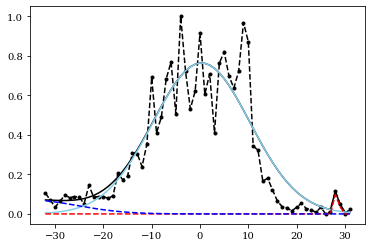

In [17]:
args = xselect,pm,order_space,image
fit_and_plot(43,3,args)

In [18]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

In [19]:
args = xselect,pm,order_space,image

def analyze_all():
    with PdfPages('peak_detection-1.pdf') as pdf:
        #for nord in tqdm(range(pm.shape[0])):
        for nord in tqdm([5,6]):
            fig, axs = akmp.figprep(600,[3,3],ratio=0.5)
            for i in range(9):
                ax = axs[i//3,i%3]
                plt.sca(ax)
                fit_and_plot(nord,i,args)
            plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.2)
            pdf.savefig()
            plt.clf()
            plt.close()
#analyze_all()

In [20]:
pm.shape[0]

44

# Save current image and pattern

In [21]:
if uniques.shape[0] == 1:
    np.savetxt('pattern_image_synthetic.txt', image)
    np.savetxt('pattern.txt', pattern.T, fmt='%.d')